<a href="https://colab.research.google.com/github/EllissaBen/music_recommendation_system/blob/main/Music_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle -q

**importing the dependencies**

In [ ]:
import os   #work with the operating system (files, folders, environment).
import json   #work with JSON data (convert between JSON and Python objects).
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer   #converts raw text into a numerical matrix of TF-IDF features.
from sklearn.metrics.pairwise import cosine_similarity
import re   #Used for pattern matching, searching, splitting, replacing, and validating text.
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

**data collection**

In [ ]:
kaggle_config = json.load(open('kaggle.json')) #open kaggle > account > settings > create a new API token

In [ ]:
kaggle_config.keys()

dict_keys(['username', 'key'])

In [ ]:
#set the environment vars:
os.environ['KAGGLE_USERNAME'] = kaggle_config['username']
os.environ['KAGGLE_KEY'] = kaggle_config['key']

In [ ]:
#loading the dataset using the kaggle API
!kaggle datasets download notshrirang/spotify-million-song-dataset

Dataset URL: https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset
License(s): CC0-1.0
  0% 0.00/20.7M [00:00<?, ?B/s]
100% 20.7M/20.7M [00:00<00:00, 1.91GB/s]


In [ ]:
!ls

kaggle.json  spotify-million-song-dataset.zip
sample_data  spotify_millsongdata.csv


In [ ]:
with zipfile.ZipFile('spotify-million-song-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [ ]:
#loading the dataset to a pandas df
df = pd.read_csv('/content/spotify_millsongdata.csv')

**initial understanding**

In [ ]:
df.shape

(57650, 4)

In [ ]:
df.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \r\nA..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \r\nTouch me gen..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \r\nWhy I had...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57650 entries, 0 to 57649
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   artist  57650 non-null  object
 1   song    57650 non-null  object
 2   link    57650 non-null  object
 3   text    57650 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [ ]:
df.isnull().sum()

,0
artist,0
song,0
link,0
text,0


In [ ]:
#top artists and songs:
top_artists = df['artist'].value_counts().head(10)
print("\nTop 10 Artists:")
print(top_artists)


Top 10 Artists:
artist
Donna Summer        191
Gordon Lightfoot    189
Bob Dylan           188
George Strait       188
Loretta Lynn        187
Alabama             187
Cher                187
Reba Mcentire       187
Chaka Khan          186
Dean Martin         186
Name: count, dtype: int64


In [ ]:
df = df.sample(10000)

df = df.drop('link', axis=1).reset_index(drop=True)

In [ ]:
df.shape

(10000, 3)

In [ ]:
df.head(5)

,artist,song,text
0,Depeche Mode,Freestate,I can hear your soul crying \r\nListen to you...
1,Human League,sky,And after such a blazing day \r\nAt last the ...
2,Rod Stewart,Loveless,"What'cha doin', what'cha doin' what'cha doin' ..."
3,System Of A Down,Tentative,Who wants to come with me and melt in the sun?...
4,Widespread Panic,Visiting Day,"Baby please, don't turn your back on me \r\nL..."


In [ ]:
# WordCloud for song lyrics
all_lyrics = " ".join(df['text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_lyrics)

**WordCloud to visualize the most common words in the lyrics.**


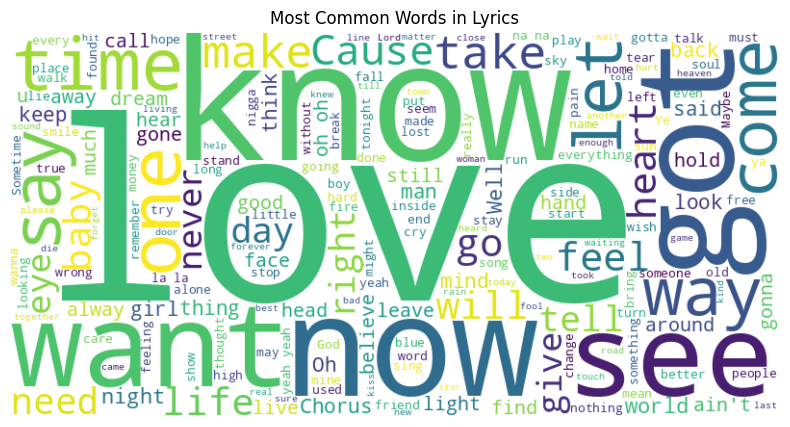

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()


**data preprocessing:**

In [ ]:
# download nltk data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words=set(stopwords.words('english'))

In [ ]:
print(stop_words)

{"we've", 'ourselves', 'your', 'myself', 'ma', "it'd", 'during', 'was', "we'd", 'until', 'be', 'has', 'the', "wouldn't", "he's", 'themselves', 'had', 'once', "shan't", "she's", 'or', 'as', 'off', 'under', 'weren', 'because', "it's", "we'll", 'y', 'hasn', 'me', 'couldn', 'yourselves', 'at', 'having', 'itself', 'didn', "wasn't", 'it', 'why', "haven't", "they're", 'did', 'she', 'him', 'more', 'will', 'same', 'am', 'ours', 'o', 'an', 'and', 'a', 'no', 'just', 'do', 'of', 'those', 'are', 'below', "they've", "you'd", 'himself', "shouldn't", 'up', "doesn't", 'they', "that'll", 'some', 'to', 'yours', 'if', 'd', 're', 'above', 'too', "couldn't", 'there', 'isn', 'but', "he'd", "she'd", 'other', 'before', 'down', 'herself', 'his', "isn't", 'my', "should've", 'its', "they'll", 'we', "i'll", 'for', 'don', 'all', 'again', 'hadn', 'when', "i've", 'through', 'haven', 'mustn', 'that', 'yourself', "she'll", "it'll", 'their', 'her', 'so', 'what', 'should', 'very', "he'll", 'this', "won't", 'here', "you'l

In [ ]:
def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [ ]:
# Apply preprocessing to lyrics
df['cleaned_text'] = df['text'].apply(preprocess_text)

In [ ]:
df.head()

,artist,song,text,cleaned_text
0,Depeche Mode,Freestate,I can hear your soul crying \r\nListen to you...,hear soul crying listen spirit sighing feel de...
1,Human League,sky,And after such a blazing day \r\nAt last the ...,blazing day last breeze began play drained gla...
2,Rod Stewart,Loveless,"What'cha doin', what'cha doin' what'cha doin' ...",whatcha doin whatcha doin whatcha doin right f...
3,System Of A Down,Tentative,Who wants to come with me and melt in the sun?...,wants come melt sun superstition taking us rid...
4,Widespread Panic,Visiting Day,"Baby please, don't turn your back on me \r\nL...",baby please dont turn back lets walk along cob...


In [ ]:
# Vectorization with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)   #Keep only the top 5000 most frequent words
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_text'])

In [ ]:
# Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [ ]:
# Recommendation Function
def recommend_songs(song_name, cosine_sim=cosine_sim, df=df, top_n=5):
    # Find the index of the song
    idx = df[df['song'].str.lower() == song_name.lower()].index
    if len(idx) == 0:
        return "Song not found in the dataset!"   # can be reworked to compare for songs not present in the dataset
    idx = idx[0]

# Get similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]

# Get song indices
    song_indices = [i[0] for i in sim_scores]

# Return top n similar songs
    return df[['artist', 'song']].iloc[song_indices]

In [ ]:
df['song'][2]

'Loveless'

In [ ]:

# Example Recommendation
print("\nRecommendations for the song 'Blinded By Rainbows':")
recommendations = recommend_songs("Loveless") # df["song"][2]
print(recommendations)


Recommendations for the song 'Blinded By Rainbows':
                  artist                           song
1381             Alabama                   That Feeling
8822     Nine Inch Nails                 Purest Feeling
3262  Kris Kristofferson               Whatcha Gonna Do
5966              Prince  Can't Stop This Feeling I Got
3771           Kim Wilde                     In My Life
